# How does preprocessing make differences in prediction accuracies?

In this document, I consider how preprocessing can make differences in prediction accuracies, using the data in [Warm Up: Machine Learning with a Heart](https://www.drivendata.org/competitions/54/machine-learning-with-a-heart/page/109/).
For the prediction model, I use a logistic regression, and the prediction accuracy is measured as log loss.

In [213]:
# Import libraries
%matplotlib inline

import numpy as np
import pandas as pd
import itertools
import random

import matplotlib.pyplot as plt
import seaborn as sns

# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.linear_model import LogisticRegression

# for combining the preprocess with model training
from sklearn.pipeline import Pipeline

# for optimizing parameters of the pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

# log loss to measure prediction accuracies
from sklearn.metrics import log_loss



I load the datasets:

In [74]:
# Load datasets for training my model
train_values = pd.read_csv('../Data/train_values.csv', index_col = 'patient_id')
train_labels = pd.read_csv('../Data/train_labels.csv', index_col = 'patient_id')

The head of the training features looks like this:

In [75]:
train_values.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


Notice that there are a couple of potential categorical variables.
One obvious one is `thal`, results of thallium stress test measuring blood flow to the heart.
This variable can take three values: `normal`, `fixed_effect`, and `reversible_defect`.
An example of ambiguous variables is `num_major_vessels`, which is the number of major vessels (0-3) colored by flurosopy.

## Construct a pipeline

In [32]:
pipe = Pipeline(steps = [('scale', StandardScaler()),
                        ('logistic', LogisticRegression())])
param_grid = {'logistic__C' : np.linspace(0.0001, 10, num = 100),
             'logistic__penalty' : ['l1', 'l2']}


## Baseline analysis 1: use selected numerical variables

As a first baseline analysis, I use selected subset of numerical variables: `sex`, `age`, `max_heart_rate_achieved`, and `resting_blood_pressure`.

In [29]:
selected_features_bl1 = ['age',
                        'sex',
                        'max_heart_rate_achieved',
                        'resting_blood_pressure']
train_values_subset_bl1 = train_values[selected_features_bl1].astype('float')
train_values_subset_bl1.head()

,age,sex,max_heart_rate_achieved,resting_blood_pressure
patient_id,,,,
0z64un,45.0,1.0,170.0,128.0
ryoo3j,54.0,0.0,158.0,110.0
yt1s1x,77.0,1.0,162.0,125.0
l2xjde,40.0,1.0,181.0,152.0
oyt4ek,59.0,1.0,145.0,178.0


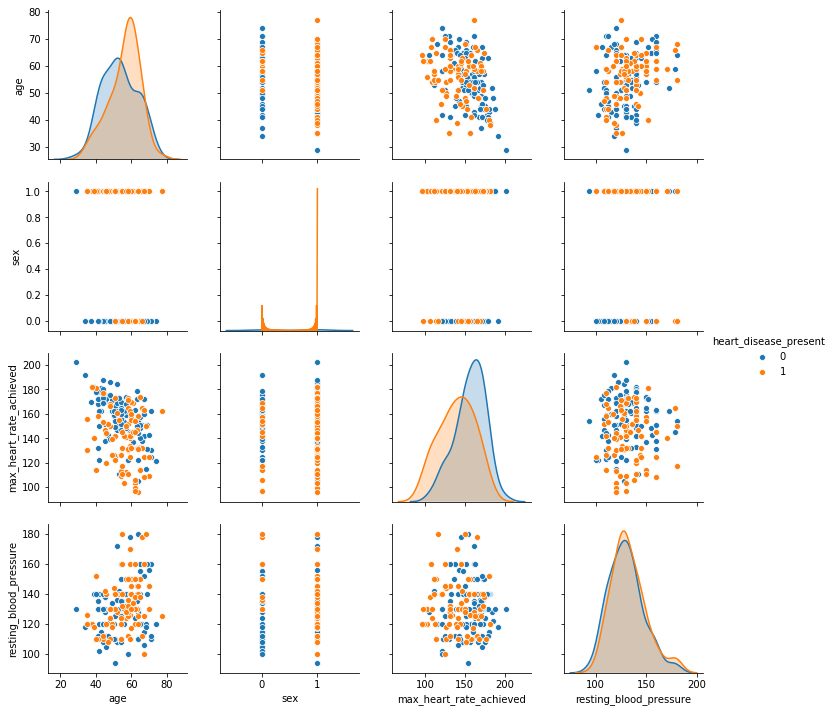

In [9]:
sns.pairplot(train_values.join(train_labels),
            hue = 'heart_disease_present',
            vars = selected_features_bl1)

In [70]:
gs = GridSearchCV(estimator = pipe,
                param_grid = param_grid,
                cv = 10)
gs_bl1.fit(train_values_subset_bl1, train_labels.heart_disease_present)

cv_score_bl1 = cross_val_score(gs_bl1, train_values_subset_bl1, train_labels.heart_disease_present, cv = 10, scoring = 'neg_log_loss')

In [71]:
- cv_score_bl1.mean()

0.5984010659505118

## Baseline analysis 2: use all numerical variables

As a first baseline analysis, I use all numerical variables in the dataset (ie. except for `thal`).

In [105]:
selected_features_bl2 = ['age',
                        'sex',
                        'max_heart_rate_achieved',
                        'resting_blood_pressure',
                        'slope_of_peak_exercise_st_segment',
                        'chest_pain_type',
                        'num_major_vessels',
                        'fasting_blood_sugar_gt_120_mg_per_dl',
                        'resting_ekg_results',
                        'serum_cholesterol_mg_per_dl',
                        'oldpeak_eq_st_depression',
                        'exercise_induced_angina']
train_values_subset_bl2 = train_values[selected_features_bl2].astype('float')
train_values_subset_bl2.head()

,age,sex,max_heart_rate_achieved,resting_blood_pressure,slope_of_peak_exercise_st_segment,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,exercise_induced_angina
patient_id,,,,,,,,,,,,
0z64un,45.0,1.0,170.0,128.0,1.0,2.0,0.0,0.0,2.0,308.0,0.0,0.0
ryoo3j,54.0,0.0,158.0,110.0,2.0,3.0,0.0,0.0,0.0,214.0,1.6,0.0
yt1s1x,77.0,1.0,162.0,125.0,1.0,4.0,3.0,0.0,2.0,304.0,0.0,1.0
l2xjde,40.0,1.0,181.0,152.0,1.0,4.0,0.0,0.0,0.0,223.0,0.0,0.0
oyt4ek,59.0,1.0,145.0,178.0,3.0,1.0,0.0,0.0,2.0,270.0,4.2,0.0


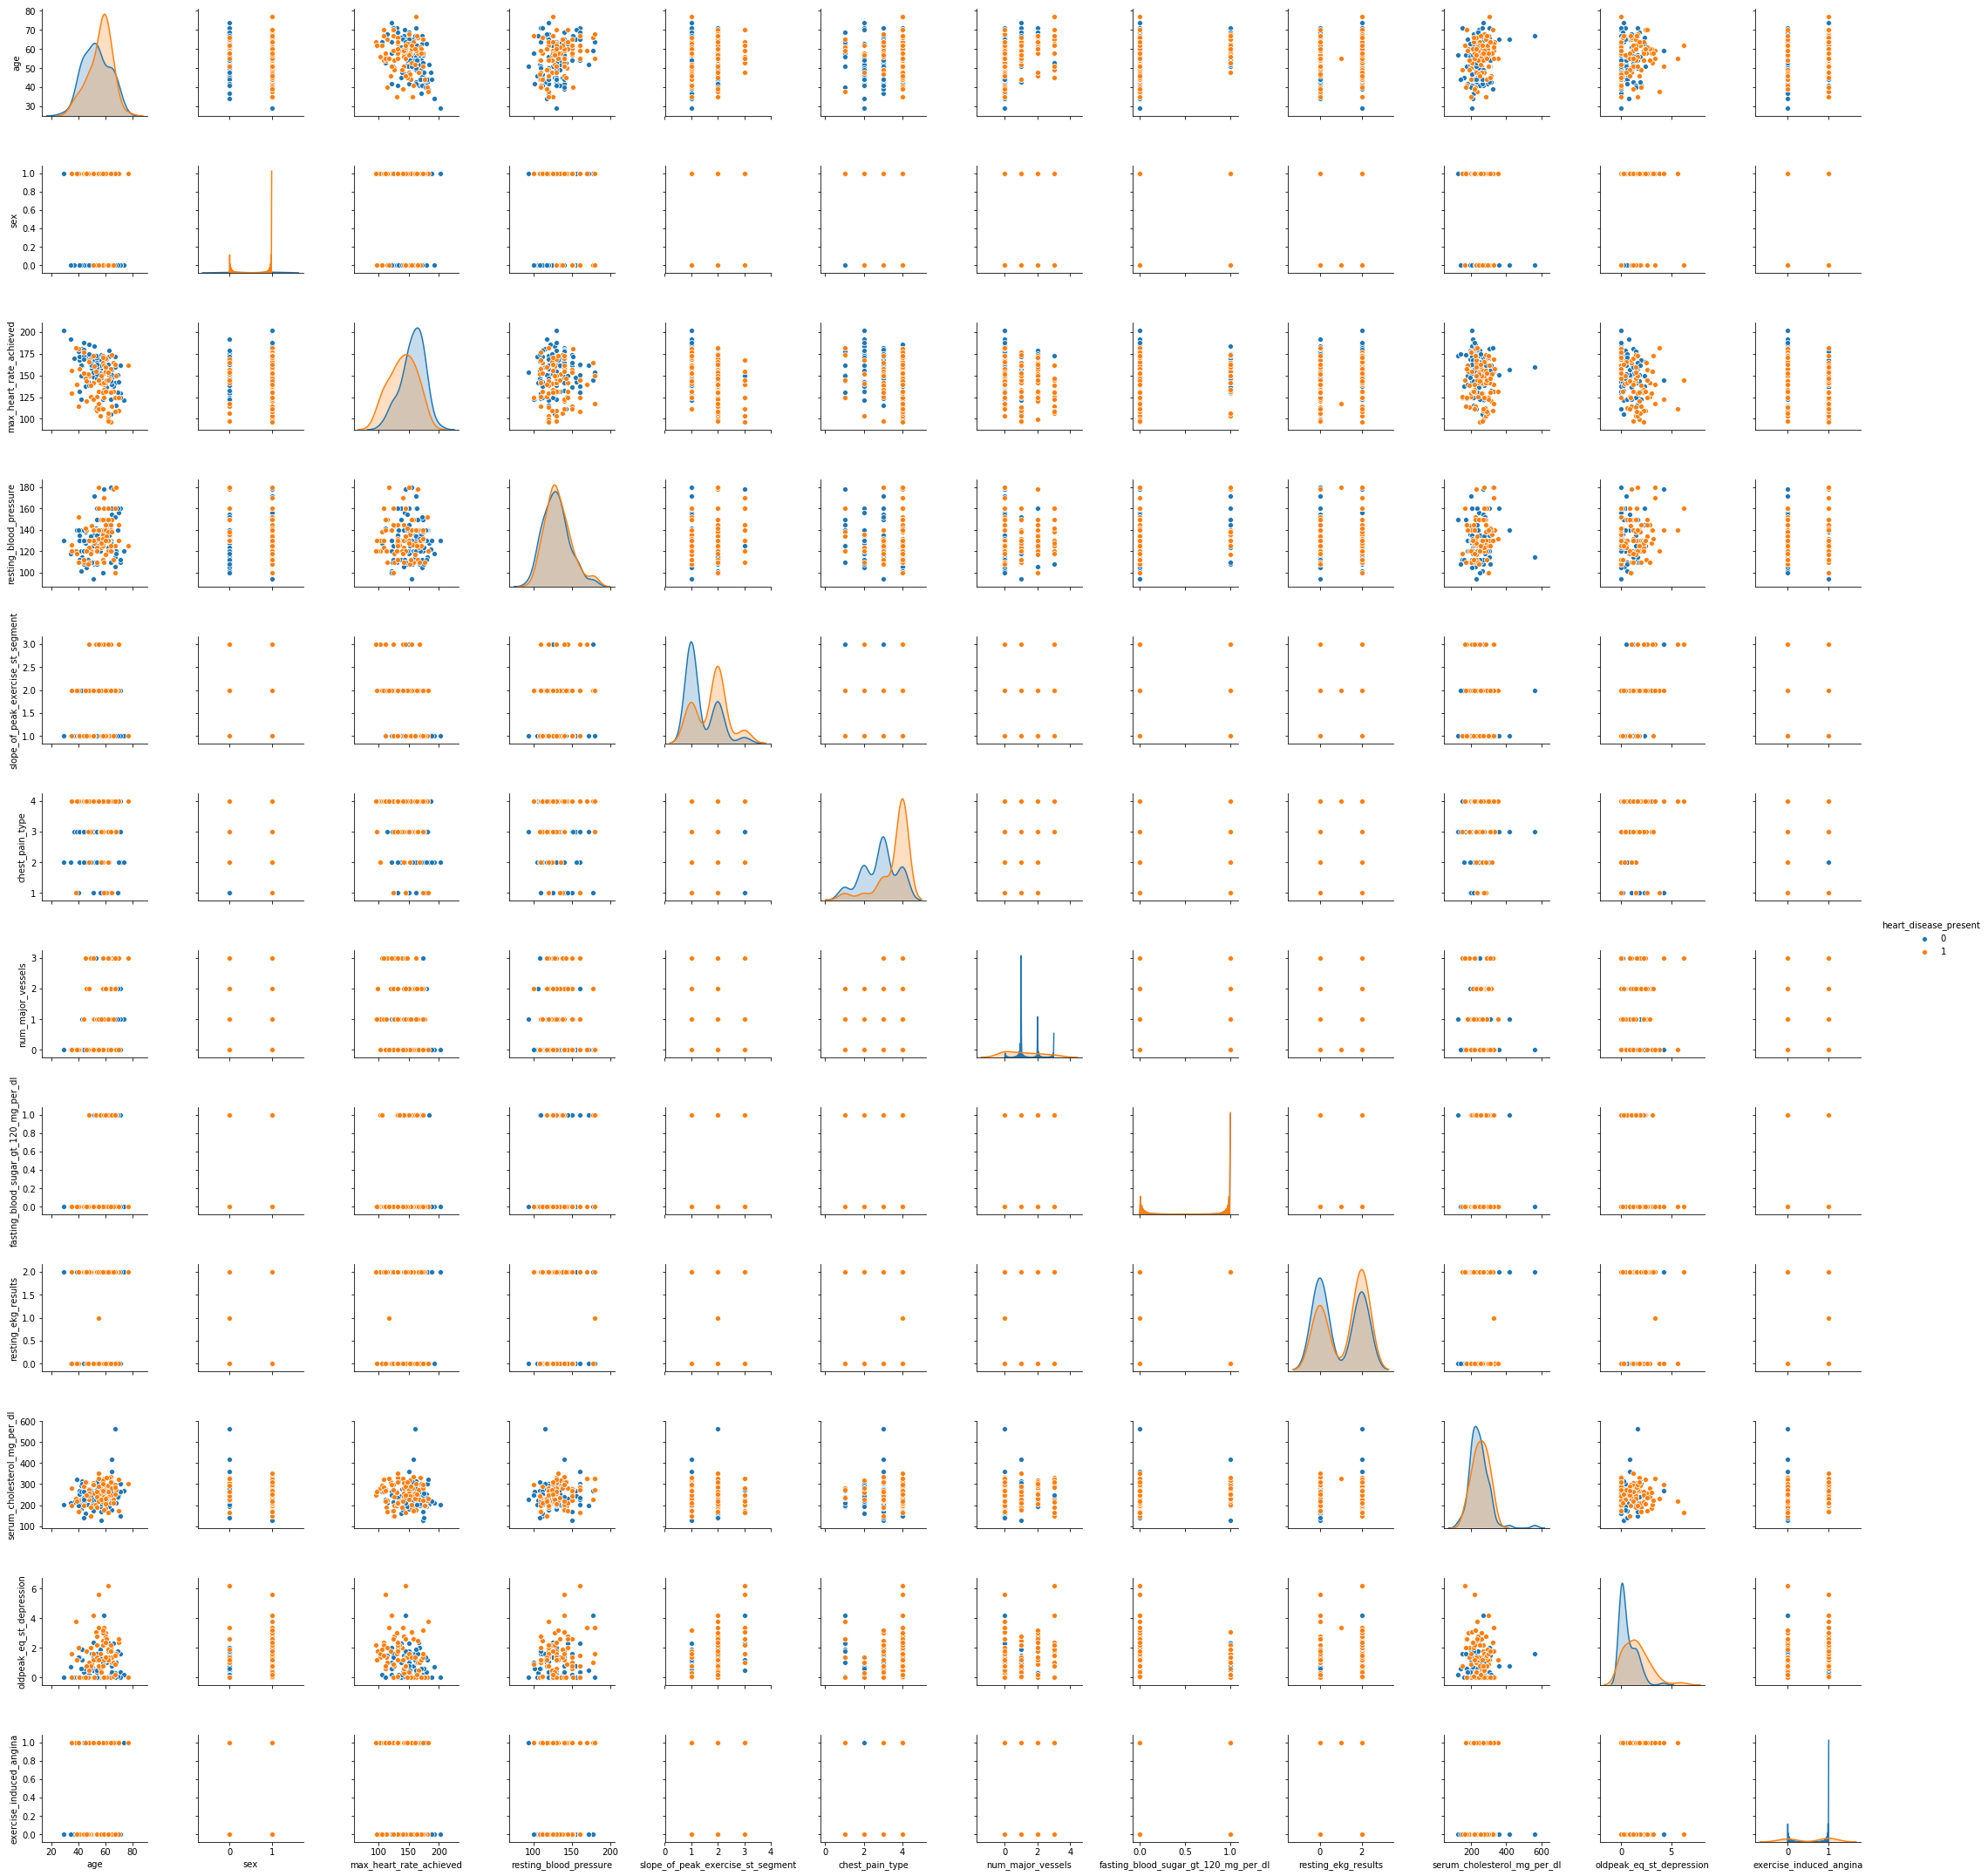

In [31]:
sns.pairplot(train_values.join(train_labels),
            hue = 'heart_disease_present',
            vars = selected_features_bl2)

In [106]:
gs_bl2 = GridSearchCV(estimator = pipe,
                     param_grid = param_grid,
                     cv = 10)
gs_bl2.fit(train_values_subset_bl2, train_labels.heart_disease_present)

cv_score_bl2 = cross_val_score(gs_bl2.best_estimator_, train_values_subset_bl2, train_labels.heart_disease_present, cv = 10, scoring = 'neg_log_loss')

In [107]:
- cv_score_bl2.mean()

0.42693753981300436

## Preprocessing 1: use `thal` as a categorical variable along with other numerical variables

In [111]:
train_values_pp1 = pd.get_dummies(train_values, columns = ['thal'], drop_first = True).astype('float')
train_values_pp1.head()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_normal,thal_reversible_defect
patient_id,,,,,,,,,,,,,,
0z64un,1.0,128.0,2.0,0.0,0.0,2.0,308.0,0.0,1.0,45.0,170.0,0.0,1.0,0.0
ryoo3j,2.0,110.0,3.0,0.0,0.0,0.0,214.0,1.6,0.0,54.0,158.0,0.0,1.0,0.0
yt1s1x,1.0,125.0,4.0,3.0,0.0,2.0,304.0,0.0,1.0,77.0,162.0,1.0,1.0,0.0
l2xjde,1.0,152.0,4.0,0.0,0.0,0.0,223.0,0.0,1.0,40.0,181.0,0.0,0.0,1.0
oyt4ek,3.0,178.0,1.0,0.0,0.0,2.0,270.0,4.2,1.0,59.0,145.0,0.0,0.0,1.0


In [113]:
gs_pp1 = GridSearchCV(estimator = pipe,
                     param_grid = param_grid,
                     cv = 10)
gs_pp1.fit(train_values_pp1, train_labels.heart_disease_present)

cv_score_pp1 = cross_val_score(gs_pp1.best_estimator_, train_values_pp1, train_labels.heart_disease_present, cv = 10, scoring = 'neg_log_loss')

In [114]:
- cv_score_pp1.mean()

0.40692670033882317

## Preprocessing 2: use `thal` and some other variables as categorical variables

On top of `thal`, I use the following variables as categorical variables: `chest_pain_type`, `num_major_vessels`, `slope_of_peak_exercise_st_segment`, and `resting_ekg_results`.

In [118]:
train_values_pp2 = pd.get_dummies(train_values, columns = ['thal', 'chest_pain_type', 'num_major_vessels', 'slope_of_peak_exercise_st_segment', 'resting_ekg_results'], drop_first = True).astype('float')
train_values_pp2.head()

,resting_blood_pressure,fasting_blood_sugar_gt_120_mg_per_dl,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_normal,thal_reversible_defect,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,num_major_vessels_1,num_major_vessels_2,num_major_vessels_3,slope_of_peak_exercise_st_segment_2,slope_of_peak_exercise_st_segment_3,resting_ekg_results_1,resting_ekg_results_2
patient_id,,,,,,,,,,,,,,,,,,,,
0z64un,128.0,0.0,308.0,0.0,1.0,45.0,170.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ryoo3j,110.0,0.0,214.0,1.6,0.0,54.0,158.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
yt1s1x,125.0,0.0,304.0,0.0,1.0,77.0,162.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
l2xjde,152.0,0.0,223.0,0.0,1.0,40.0,181.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oyt4ek,178.0,0.0,270.0,4.2,1.0,59.0,145.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [119]:
gs_pp2 = GridSearchCV(estimator = pipe,
                     param_grid = param_grid,
                     cv = 10)
gs_pp2.fit(train_values_pp2, train_labels.heart_disease_present)

cv_score_pp2 = cross_val_score(gs_pp2.best_estimator_, train_values_pp2, train_labels.heart_disease_present, cv = 10, scoring = 'neg_log_loss')

In [120]:
- cv_score_pp2.mean()

0.4475455260130855

In [125]:
data_columns = list(train_values.columns)
cat_var_candidate = ['chest_pain_type', 'num_major_vessels', 'slope_of_peak_exercise_st_segment', 'resting_ekg_results']
                     
cat_var_list = []
best_mean_cv_list = []
for L in range(0, len(cat_var_candidate) + 1):
    for cat_var in itertools.combinations(cat_var_candidate, L):
        cat_var = list(cat_var)
        cat_var.append('thal')
        train_values_pp_cat = pd.get_dummies(train_values, columns = cat_var, drop_first = True).astype('float')
        gs_cv = GridSearchCV(estimator = pipe,
                            param_grid = param_grid,
                            cv = 10)
        gs_cv.fit(train_values_pp_cat, train_labels.heart_disease_present)
        random.seed(10)
        best_mean_cv = - cross_val_score(gs_cv.best_estimator_, train_values_pp_cat, train_labels.heart_disease_present, cv = 10, scoring = 'neg_log_loss').mean()
        cat_var_list.append(cat_var)
        best_mean_cv_list.append(best_mean_cv)



In [127]:
log_loss_table = pd.DataFrame(data = {'cat_var_list': cat_var_list, 'mean_log_loss': best_mean_cv_list})
log_loss_table


,cat_var_list,mean_log_loss
0,[thal],0.406927
1,"[chest_pain_type, thal]",0.425746
2,"[num_major_vessels, thal]",0.410455
3,"[slope_of_peak_exercise_st_segment, thal]",0.404856
4,"[resting_ekg_results, thal]",0.407707
5,"[chest_pain_type, num_major_vessels, thal]",0.426997
6,"[chest_pain_type, slope_of_peak_exercise_st_se...",0.426453
7,"[chest_pain_type, resting_ekg_results, thal]",0.432221
8,"[num_major_vessels, slope_of_peak_exercise_st_...",0.408607
9,"[num_major_vessels, resting_ekg_results, thal]",0.411208


In [149]:
thal_summarize = train_values.join(train_labels).groupby('thal')['heart_disease_present'].value_counts(normalize = True).unstack()
chest_pain_type_summarize = train_values.join(train_labels).groupby('chest_pain_type')['heart_disease_present'].value_counts(normalize = True).unstack()
num_major_vessels_summarize = train_values.join(train_labels).groupby('num_major_vessels')['heart_disease_present'].value_counts(normalize = True).unstack()
slope_of_peak_exercise_st_segment_summarize = train_values.join(train_labels).groupby('slope_of_peak_exercise_st_segment')['heart_disease_present'].value_counts(normalize = True).unstack()
resting_ekg_results_summarize = train_values.join(train_labels).groupby('resting_ekg_results')['heart_disease_present'].value_counts(normalize = True).unstack()

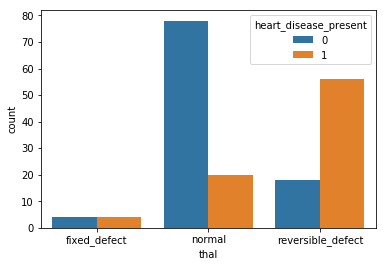

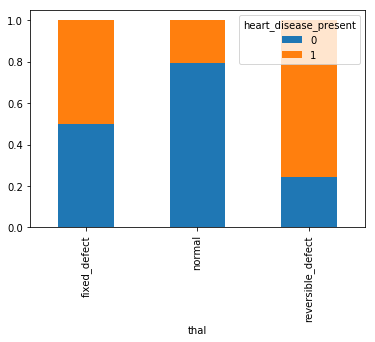

In [164]:
sns.countplot(x = 'thal', hue = 'heart_disease_present', data = train_values.join(train_labels), order = ['fixed_defect', 'normal', 'reversible_defect'])
thal_summarize.plot(kind = 'bar', stacked = True)

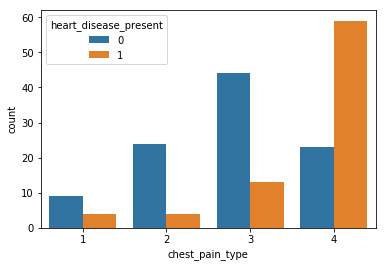

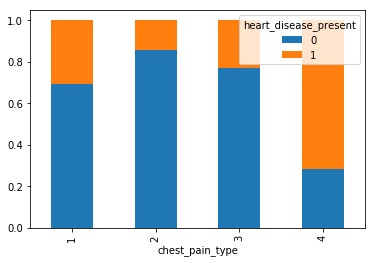

In [161]:
sns.countplot(x = 'chest_pain_type', hue = 'heart_disease_present', data = train_values.join(train_labels))
chest_pain_type_summarize.plot(kind = 'bar', stacked = True)

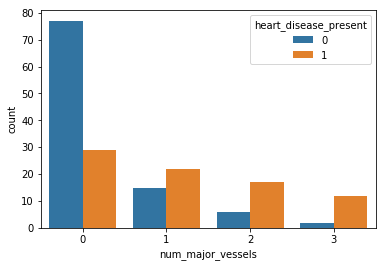

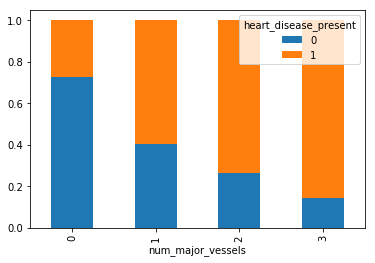

In [162]:
sns.countplot(x = 'num_major_vessels', hue = 'heart_disease_present', data = train_values.join(train_labels))
num_major_vessels_summarize.plot(kind = 'bar', stacked = True)

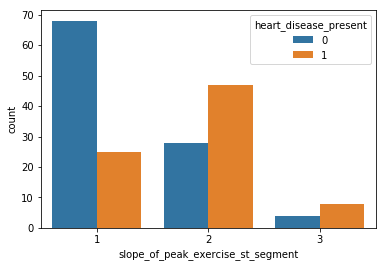

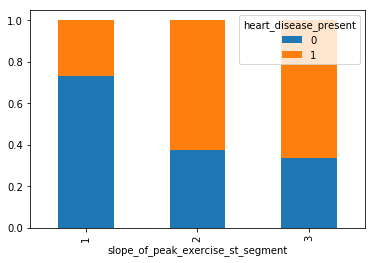

In [159]:
sns.countplot(x = 'slope_of_peak_exercise_st_segment', hue = 'heart_disease_present', data = train_values.join(train_labels))
slope_of_peak_exercise_st_segment_summarize.plot(kind = 'bar', stacked = True)

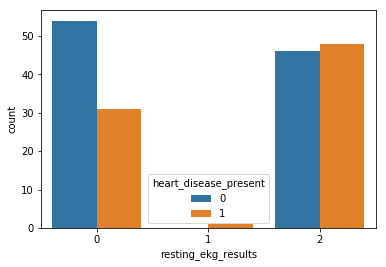

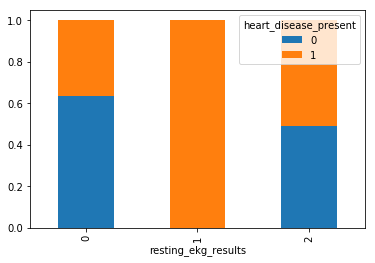

In [163]:
sns.countplot(x = 'resting_ekg_results', hue = 'heart_disease_present', data = train_values.join(train_labels))
resting_ekg_results_summarize.plot(kind = 'bar', stacked = True)

## Dimensionality reduction

One of the most important things to do for dimension reduction is to standardize variables in advance.
This is especially important when a dimensionality reduction method uses nearest neighbor methods.

Various methods for dimensionality reduction are listed [here](https://scikit-learn.org/stable/modules/manifold.html).

### Principal component analysis (PCA)

In PCA, we reduce the dimension of features so that the variances of the newly created variables are large.
The axes of the created variables are called principal components.

How many principal components are used (i.e. how much we reduce the feature dimension) is a hyperparameter.

In [221]:
from sklearn.decomposition import PCA

cv_score_pca_n = []
for n in range(1, train_values_pp1.shape[1] + 1):
    pipe_pca = Pipeline(steps = [('scale', StandardScaler()),
                                 ('pca', PCA(n_components = n)),
                                ('logistic', LogisticRegression())])
    param_grid_pca = {'logistic__C' : np.linspace(0.0001, 10, num = 100),
                      'logistic__penalty' : ['l1', 'l2']}
    np.random.seed(10)
    gs_pca = GridSearchCV(estimator = pipe_pca,
                         param_grid = param_grid_pca,
                         cv = 10)
    gs_pca.fit(train_values_pp1, train_labels.heart_disease_present)

    cv_score_pca = cross_val_score(gs_pca.best_estimator_, train_values_pp1, train_labels.heart_disease_present, cv = 10, scoring = 'neg_log_loss').mean()
    cv_score_pca_n.append(-cv_score_pca)


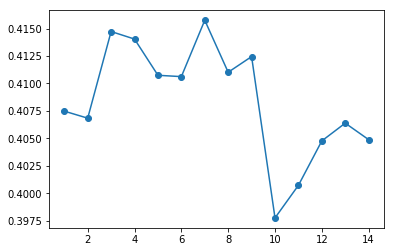

In [222]:
plt.plot(range(1, train_values_pp1.shape[1] + 1), cv_score_pca_n, marker = 'o')

It is easy to incorporate the tuning process of the number of principal components into the pipeline:

In [226]:
from sklearn.decomposition import PCA

pipe_pca = Pipeline(steps = [('scale', StandardScaler()),
                             ('pca', PCA()),
                            ('logistic', LogisticRegression())])
param_grid_pca = {'logistic__C' : np.linspace(0.0001, 10, num = 100),
                  'pca__n_components' : range(1, train_values_pp1.shape[1]),
                  'logistic__penalty' : ['l1', 'l2']}


In [227]:
np.random.seed(10)
gs_pca = GridSearchCV(estimator = pipe_pca,
                     param_grid = param_grid_pca,
                     cv = 10)
gs_pca.fit(train_values_pp1, train_labels.heart_disease_present)

cv_score_pca = cross_val_score(gs_pca.best_estimator_, train_values_pp1, train_labels.heart_disease_present, cv = 10, scoring = 'neg_log_loss')

### Linear discriminant analysis (LDA)

While LDA is pretty similar to PCA, LDA is a supervised method: LDA uses label information as well.
The reduced dimension is at most (the number of class labels - 1).
Hence in this example, the reduced dimension is 1.

In [229]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
pipe_lda = Pipeline(steps = [('scale', StandardScaler()),
                             ('lda', LDA(n_components = 1)),
                            ('logistic', LogisticRegression())])
param_grid_lda = {'logistic__C' : np.linspace(0.0001, 10, num = 100),
                  'logistic__penalty' : ['l1', 'l2']}



In [230]:
np.random.seed(10)
gs_lda = GridSearchCV(estimator = pipe_lda,
                     param_grid = param_grid_lda,
                     cv = 10)
gs_lda.fit(train_values_pp1, train_labels.heart_disease_present)

cv_score_lda = cross_val_score(gs_lda.best_estimator_, train_values_pp1, train_labels.heart_disease_present, cv = 10, scoring = 'neg_log_loss')

In [231]:
- cv_score_lda.mean()

0.4236960126110002

### Kernel PCA (KPCA)

Both PCA and LDA just used the original features, but potentially nonlinear transformations of features can be useful for classification.
KPCA basically generates new dimensions using kernel functions and then uses PCA to reduce the feature dimensions.

In [247]:
from sklearn.decomposition import KernelPCA
pipe_kcpa = Pipeline(steps = [('scale', StandardScaler()),
                             ('kcpa', KernelPCA(kernel = 'rbf')),
                            ('logistic', LogisticRegression())])
param_grid_kcpa = {'logistic__C' : np.linspace(0.0001, 1, num = 10),
                  'kcpa__n_components' : range(1, 15),
                  'kcpa__gamma' : np.linspace(0.01, 1, num = 10),
                  'logistic__penalty' : ['l1', 'l2']}



In [248]:
np.random.seed(10)
gs_kcpa = GridSearchCV(estimator = pipe_kcpa,
                     param_grid = param_grid_kcpa,
                     cv = 10)
gs_kcpa.fit(train_values_pp1, train_labels.heart_disease_present)

cv_score_kcpa = cross_val_score(gs_kcpa.best_estimator_, train_values_pp1, train_labels.heart_disease_present, cv = 10, scoring = 'neg_log_loss')

In [254]:
gs_kcpa.best_estimator_.steps[1][1].gamma

0.01

In [249]:
- cv_score_kcpa.mean()

0.5284951794248043

## Appendix

In [179]:
from sklearn.cross_decomposition import PLSRegression
X = train_values.num_major_vessels
X = pd.get_dummies(X, drop_first = True)
Y = train_labels.heart_disease_present
pls2 = PLSRegression(n_components=2)
pls2.fit(X, Y)

Y_pred = pls2.predict(X)

In [191]:
pd.DataFrame(data = pls2.fit_transform(X,Y)[0]).head(20)

,0,1
0,-0.642104,-0.374271
1,-0.642104,-0.374271
2,1.817478,-1.612034
3,-0.642104,-0.374271
4,-0.642104,-0.374271
5,-0.642104,-0.374271
6,1.214830,-0.486054
7,0.396683,1.984335
8,-0.642104,-0.374271
9,-0.642104,-0.374271


In [192]:
X.head(20)

,1,2,3
patient_id,,,
0z64un,0,0,0
ryoo3j,0,0,0
yt1s1x,0,0,1
l2xjde,0,0,0
oyt4ek,0,0,0
ldukkw,0,0,0
2gbyh9,0,1,0
daa9kp,1,0,0
3nwy2n,0,0,0
